# Hovercraft Problem

We are in control of a hovercraft in a 2-dimensional plane. We wish to hit a set of waypoints at specific times over the course of 60 seconds. We can control the hovercraft by adding thrust (in either or both of the dimensions) at each second over the course of the minute. Our goal is to hit the waypoints while minimizing fuel usage. We do not require that the waypoints are hit exactly. Instead, we view this optimization problem as a tradeoff between fuel useage and hitting the waypoints as closely as possible.

To formulate this problem, we consider a single minute discretized into seconds, $t = 1,\dots, 60$. There is a set of 4 waypoints, at times $T = [1, 20, 50, 60]$ with coordinates (in 2-d):
\begin{equation*}
\text{waypoints} = w = \left[\begin{matrix} 1 & 4 & 6 & 1 \\
									1 & 3 & 0 & 1  \end{matrix}\right].
\end{equation*}
Note that we intend to end where we started. To define the dynamics of the hovercraft, we use the variables: position $x_t$, velocity $v_t$, thrust $u_t$. The dynamics of our hovercraft are:
\begin{equation*}
x_{t+1} = x_t + v_t, \quad v_{t+1} = v_t + u_t, \quad \text{for all } \ t=1,\dots,59.
\end{equation*}
Note that these variables are all 2-d vectors. The initial position of the hovercraft is $x_1 = [1,1]^T$ and the initial velocity is $v_1 = [0,0]^T$. To track the fuel use, we use the squared Euclidean norm of $u$, that is $\|u\|^2 = u_1^2 + \dots + u_{60}^2$. In addition, to track how much the way points are missed by, we use the sum of the squared Euclidean distances, i.e., $\|x_1-w_1\|^2 + \|x_{20}-w_2\|^2 + \|x_{50}-w_3\|^2+ \|x_{60} - w_4\|^2$ (recall the definition of the Euclidean distance in the previous question).

Formulate this as a nonlinear optimization problem in JuMP and use the Ipopt solver to solve it. Create decision variables $x$, $v$, and $u$ which are indexed over the dimension of the problem and the number of timesteps, i.e. for a model $m$
\begin{equation*}
\texttt{@variable(m, x[1:2,1:60])}
\end{equation*}
The objective function should trade off between the fuel usage and the accuracy of matching the waypoints. Specifically, for some $\lambda > 0$, the objective should have the form
\begin{equation*}
\min \quad \|u\|^2 + \lambda \sum_{i=1}^4 \|x_{T_i} - w_i\|^2,
\end{equation*}
where $T_i$ is the time at which we want to be at waypoint $w_i$.

Starting code is provided in this notebook. There are two parts to this problem
- Part A) Model and solve this problem with $\lambda = 0.01$. As a reminder, to type the symbol $\lambda$ in Julia, type \\lambda and press the tab key on your keyboard. Make sure that the variable $x$ is defined as above. The code provided will then plot the path taken by the optimal solution.
- Part B) Model and solve this problem for 30 values of $\lambda$ log spaced between $10^{-5}$ and $10$. The code provided will create these values and has comments to denote where to place your model. You should define the variables and constraints once (prior to the loop) while the objective function should be defined each time through the loop, for a new value of $\lambda$. Once you have solved all 30 problems, the code will plot the Pareto curve displaying the tradeoff between fuel usage and waypoint mismatch.

Problem data:

In [1]:
# Number of waypoints
k = 4
# Vector of timestamps
T = zeros(Int,k)
# Vector of waypoint locations
waypoints = zeros(2,k)

#Set up timestamps
T[1] = 1
T[2] = 20
T[3] = 50
T[4] = 60

endtime = 60

# Define the waypoints
# Each column is a waypoint (in 2-d)
waypoints = [ 1   4   6   1;
              1   3   0   1 ]
;

### Part A

In [2]:
using JuMP, Ipopt, LinearAlgebra

#To type λ in Julia, type \lambda then press TAB on your keyboard
λ = 0.01

m = Model(Ipopt.Optimizer)

#Define your model HERE
@variable(m, x[1:2, 1:60])
@variable(m, v[1:2, 1:60])
@variable(m, u[1:2, 1:60])

@constraint(m, init_pos, x[:,1] .== [1; 1])
@constraint(m, init_vel, v[:,1] .== [0; 0])

@constraint(m, end_pos, x[:,60] .== [1; 1])

@constraint(m, dynamic[i in 1:59], x[:, i+1] .== x[:,i] + v[:, i])
@constraint(m, dynamic2[i in 1:59], v[:, i+1] .== v[:,i] + u[:, i])

@NLexpression(m, fuel_cost, sum(sqrt(u[1, i]^2 + u[2, i]^2)^2 for i in 1:60))
@NLexpression(m, waypoint_accuracy, sum(sqrt((x[1, T[i]]-waypoints[1, i])^2 + (x[2, T[i]]-waypoints[2, i])^2)^2 for i in 1:4))

@NLobjective(m, Min, fuel_cost + λ * waypoint_accuracy)

#@NLobjective(m, Min, sum(norm(u[:,i])^2 for i in 1:60)) # + λ*sum((norm(x[:,T[i]] - waypoints[:,i])^2) for i in 1:4))

optimize!(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      714
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      192

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      242
Total number of inequality co

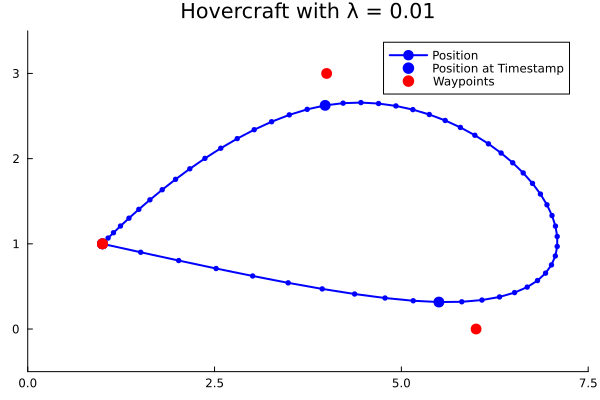

In [3]:
using Plots

#Plot the solution for λ = 0.01
x = value.(x)

plot(x[1,:], x[2,:], linewidth = 2, linecolor = :blue, markersize=3,
    markershape = :circle, markercolor = :blue, markerstrokewidth = 0, label = "Position")
plot!(x[1,T], x[2,T], seriestype = :scatter, markersize=6,
     markercolor = :blue, markerstrokewidth = 0, label = "Position at Timestamp" )
plot!(waypoints[1,:], waypoints[2,:], seriestype = :scatter, markersize=6,
    markercolor = :red, markerstrokewidth = 0, grid = false, xlims = [0,7.5],
    ylims = [-0.5,3.5], label = "Waypoints", title = "Hovercraft with λ = 0.01" )

### Part B

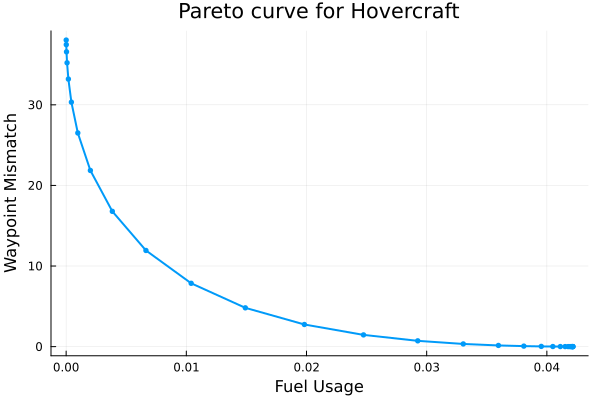

In [4]:
#Try 30 different values of lambda, logspace between
#10^-5 and 10^1
numtrials = 30
lambdas = 10 .^ LinRange(-5,1,30)

m2 = Model(Ipopt.Optimizer)

#Don't make the solver output info while solving
set_silent(m2)

#Insert the variables and constraints of your model here
@variable(m2, x[1:2, 1:60])
@variable(m2, v[1:2, 1:60])
@variable(m2, u[1:2, 1:60])

@constraint(m2, init_pos, x[:,1] .== [1; 1])
@constraint(m2, init_vel, v[:,1] .== [0; 0])

@constraint(m2, end_pos, x[:,60] .== [1; 1])

@constraint(m2, dynamic[i in 1:59], x[:, i+1] .== x[:,i] + v[:, i])
@constraint(m2, dynamic2[i in 1:59], v[:, i+1] .== v[:,i] + u[:, i])

@NLexpression(m2, fuel_cost, sum(sqrt(u[1, i]^2 + u[2, i]^2)^2 for i in 1:60))
@NLexpression(m2, waypoint_accuracy, sum(sqrt((x[1, T[i]]-waypoints[1, i])^2 + (x[2, T[i]]-waypoints[2, i])^2)^2 for i in 1:4))

#Calculate amount of fuel used in each trial
normu = zeros(numtrials)
#Calculate amount of mismatch in each trial
normdiff = zeros(numtrials)

#Keep track of the trial number
i = 1
for λ in lambdas
        #Insert your objective with the current value of λ HERE
        @NLobjective(m2, Min, fuel_cost + λ * waypoint_accuracy)
        
        optimize!(m2)

        #Calculate amount of fuel used in this trial
        normu[i] = sum((value.(u)).^2)
        #Calculate waypoint mismatch in this trial
        normdiff[i] = sum((value.(x)[:,T]-value.(waypoints)).^2)
        i = i+1
end
;

#Plot the Pareto curve, which tradesoff between fuel usage and mismatch
plot( normu, normdiff, title="Pareto curve for Hovercraft", xlabel = "Fuel Usage", ylabel = "Waypoint Mismatch",
      linewidth = 2, markersize = 3, markerstrokewidth = 0, markershape = :circle, label = "")